In [42]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## load dataset

In [43]:
filepath =  "/content/gdrive/MyDrive/Fall 2022/05_aml/AML Final Project/2_Milestone/2_train_sample.csv"
filepath2 =  "/content/gdrive/MyDrive/Fall 2022/05_aml/AML Final Project/2_Milestone/2_test_sample.csv"

In [44]:
import pandas as pd
import numpy as np

In [45]:
df1=pd.read_csv(filepath,parse_dates=['CMPLNT_FR_DT','CMPLNT_FR_TM','CMPLNT_TO_DT','CMPLNT_TO_TM'])
df2=pd.read_csv(filepath2,parse_dates=['CMPLNT_FR_DT','CMPLNT_FR_TM','CMPLNT_TO_DT','CMPLNT_TO_TM'])

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [46]:
df1.shape

(131028, 38)

In [47]:
df2.shape

(38679, 38)

In [48]:
#concat to make preprocess easier
df=pd.concat([df1,df2])

In [49]:
df.shape

(169707, 38)

In [50]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'CMPLNT_NUM', 'CMPLNT_FR_DT',
       'CMPLNT_FR_TM', 'CMPLNT_TO_DT', 'CMPLNT_TO_TM', 'ADDR_PCT_CD', 'RPT_DT',
       'KY_CD', 'OFNS_DESC', 'PD_CD', 'PD_DESC', 'CRM_ATPT_CPTD_CD',
       'LAW_CAT_CD', 'BORO_NM', 'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC',
       'JURIS_DESC', 'JURISDICTION_CODE', 'PARKS_NM', 'HADEVELOPT',
       'HOUSING_PSA', 'X_COORD_CD', 'Y_COORD_CD', 'SUSP_AGE_GROUP',
       'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT', 'Latitude', 'Longitude',
       'Lat_Lon', 'PATROL_BORO', 'STATION_NAME', 'VIC_AGE_GROUP', 'VIC_RACE',
       'VIC_SEX', 'New Georeferenced Column'],
      dtype='object')

In [51]:
#split the time to create features like year,month,hour and dow
df['YEAR']=df['CMPLNT_FR_DT'].dt.year
df['MONTH']=df['CMPLNT_FR_DT'].dt.month
df['Hour']=df['CMPLNT_FR_TM'].dt.hour
df['DoW']=df['CMPLNT_FR_DT'].dt.dayofweek #sunday,monday...

In [52]:
# Drop unnecessary columns
df.drop(labels=["Unnamed: 0", "Unnamed: 0.1","PARKS_NM",  "STATION_NAME", "PATROL_BORO", "TRANSIT_DISTRICT", 
             "SUSP_SEX", "SUSP_RACE", "SUSP_AGE_GROUP", "X_COORD_CD", "Y_COORD_CD", "HOUSING_PSA", "HADEVELOPT", 
             "JURISDICTION_CODE", "JURIS_DESC", "JURIS_DESC", "RPT_DT", "JURIS_DESC", "PREM_TYP_DESC",
             "PD_CD", "PD_DESC", "CMPLNT_TO_TM", "CMPLNT_TO_DT", "LOC_OF_OCCUR_DESC", "CMPLNT_FR_TM",'Latitude', 'Longitude','Lat_Lon','New Georeferenced Column'],axis=1,inplace=True)

In [53]:
df.columns

Index(['CMPLNT_NUM', 'CMPLNT_FR_DT', 'ADDR_PCT_CD', 'KY_CD', 'OFNS_DESC',
       'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'BORO_NM', 'VIC_AGE_GROUP',
       'VIC_RACE', 'VIC_SEX', 'YEAR', 'MONTH', 'Hour', 'DoW'],
      dtype='object')

In [54]:
#rename it
df.columns=['Complaint_ID','Date','Neighborhood','Offence_Code','Offence_Type','Status','Offence_Level','Borough','Victim_Agegroup','Victim_Race','Victim_Sex',
            'Year', 'Month','Hour', 'DoW']

In [55]:
df.head()

,Complaint_ID,Date,Neighborhood,Offence_Code,Offence_Type,Status,Offence_Level,Borough,Victim_Agegroup,Victim_Race,Victim_Sex,Year,Month,Hour,DoW
0,871087790,2020-11-22,112.0,344,ASSAULT 3 & RELATED OFFENSES,COMPLETED,MISDEMEANOR,QUEENS,45-64,WHITE,F,2020,11,13,6
1,349840324,2019-01-26,68.0,341,PETIT LARCENY,COMPLETED,MISDEMEANOR,BROOKLYN,UNKNOWN,UNKNOWN,D,2019,1,18,5
2,355831147,2021-07-19,79.0,351,CRIMINAL MISCHIEF & RELATED OF,COMPLETED,MISDEMEANOR,BROOKLYN,45-64,BLACK,F,2021,7,14,0
3,934500497,2020-01-19,19.0,341,PETIT LARCENY,COMPLETED,MISDEMEANOR,MANHATTAN,UNKNOWN,UNKNOWN,D,2020,1,17,6
4,988492438,2021-09-24,47.0,347,INTOXICATED & IMPAIRED DRIVING,COMPLETED,MISDEMEANOR,BRONX,UNKNOWN,UNKNOWN,E,2021,9,4,4


## data preprocessing

1. missing value(delete all rows with null value)  
2. left join with holiday dataset to create the feature Holiday(0&1)  
3. control the category to remove some outlier  
4. label encoder to turn text to numerical value

In [56]:
#dealing with missing value
df.isnull().sum().sort_values(ascending=False)

Borough            191
Status              11
Victim_Race          8
Offence_Type         3
Neighborhood         2
Complaint_ID         0
Date                 0
Offence_Code         0
Offence_Level        0
Victim_Agegroup      0
Victim_Sex           0
Year                 0
Month                0
Hour                 0
DoW                  0
dtype: int64

In [57]:
#delete all rows with null value
df.dropna(how='any',axis=0,inplace=True)

In [58]:
#left join with holiday to create the feature Holiday with bonary value,dataset from Kaggle https://www.kaggle.com/datasets/donnetew/us-holiday-dates-2004-2021, add 2022 data manually
filepath3 =  "/content/gdrive/MyDrive/Fall 2022/05_aml/AML Final Project/2_Milestone/US_Holiday.csv"
df3=pd.read_csv(filepath3,parse_dates=['Date'],usecols=['Date','Holiday'],encoding = 'unicode_escape')
df3.head()

,Date,Holiday
0,2004-07-04,4th of July
1,2005-07-04,4th of July
2,2006-07-04,4th of July
3,2007-07-04,4th of July
4,2008-07-04,4th of July


In [59]:
df=pd.merge(df,df3,left_on='Date',right_on='Date',how='left')
df.head()

,Complaint_ID,Date,Neighborhood,Offence_Code,Offence_Type,Status,Offence_Level,Borough,Victim_Agegroup,Victim_Race,Victim_Sex,Year,Month,Hour,DoW,Holiday
0,871087790,2020-11-22,112.0,344,ASSAULT 3 & RELATED OFFENSES,COMPLETED,MISDEMEANOR,QUEENS,45-64,WHITE,F,2020,11,13,6,NaN
1,349840324,2019-01-26,68.0,341,PETIT LARCENY,COMPLETED,MISDEMEANOR,BROOKLYN,UNKNOWN,UNKNOWN,D,2019,1,18,5,NaN
2,355831147,2021-07-19,79.0,351,CRIMINAL MISCHIEF & RELATED OF,COMPLETED,MISDEMEANOR,BROOKLYN,45-64,BLACK,F,2021,7,14,0,NaN
3,934500497,2020-01-19,19.0,341,PETIT LARCENY,COMPLETED,MISDEMEANOR,MANHATTAN,UNKNOWN,UNKNOWN,D,2020,1,17,6,NaN
4,988492438,2021-09-24,47.0,347,INTOXICATED & IMPAIRED DRIVING,COMPLETED,MISDEMEANOR,BRONX,UNKNOWN,UNKNOWN,E,2021,9,4,4,NaN


In [60]:
#create Holiday
df['Holiday'].fillna(value=0,inplace=True)
df.loc[df['Holiday']!=0,'Holiday']=1

In [61]:
df.head()

,Complaint_ID,Date,Neighborhood,Offence_Code,Offence_Type,Status,Offence_Level,Borough,Victim_Agegroup,Victim_Race,Victim_Sex,Year,Month,Hour,DoW,Holiday
0,871087790,2020-11-22,112.0,344,ASSAULT 3 & RELATED OFFENSES,COMPLETED,MISDEMEANOR,QUEENS,45-64,WHITE,F,2020,11,13,6,0
1,349840324,2019-01-26,68.0,341,PETIT LARCENY,COMPLETED,MISDEMEANOR,BROOKLYN,UNKNOWN,UNKNOWN,D,2019,1,18,5,0
2,355831147,2021-07-19,79.0,351,CRIMINAL MISCHIEF & RELATED OF,COMPLETED,MISDEMEANOR,BROOKLYN,45-64,BLACK,F,2021,7,14,0,0
3,934500497,2020-01-19,19.0,341,PETIT LARCENY,COMPLETED,MISDEMEANOR,MANHATTAN,UNKNOWN,UNKNOWN,D,2020,1,17,6,0
4,988492438,2021-09-24,47.0,347,INTOXICATED & IMPAIRED DRIVING,COMPLETED,MISDEMEANOR,BRONX,UNKNOWN,UNKNOWN,E,2021,9,4,4,0


In [62]:
#control the category
df=df[df['Borough'].isin(['BROOKLYN','BRONX','QUEENS','MANHATTAN','STATEN ISLAND'])]
df=df[df['Victim_Sex'].isin(['F','M','D','E'])]
df=df[df['Victim_Agegroup'].isin(['25-44','45-64','18-24','65+','<18','UNKNOWN'])]
df=df[df['Victim_Race'].isin(['WHITE', 'WHITE HISPANIC', 'ASIAN / PACIFIC ISLANDER', 'BLACK','UNKNOWN', 'BLACK HISPANIC', 'AMERICAN INDIAN/ALASKAN NATIVE'])]

In [63]:
df.head()

,Complaint_ID,Date,Neighborhood,Offence_Code,Offence_Type,Status,Offence_Level,Borough,Victim_Agegroup,Victim_Race,Victim_Sex,Year,Month,Hour,DoW,Holiday
0,871087790,2020-11-22,112.0,344,ASSAULT 3 & RELATED OFFENSES,COMPLETED,MISDEMEANOR,QUEENS,45-64,WHITE,F,2020,11,13,6,0
1,349840324,2019-01-26,68.0,341,PETIT LARCENY,COMPLETED,MISDEMEANOR,BROOKLYN,UNKNOWN,UNKNOWN,D,2019,1,18,5,0
2,355831147,2021-07-19,79.0,351,CRIMINAL MISCHIEF & RELATED OF,COMPLETED,MISDEMEANOR,BROOKLYN,45-64,BLACK,F,2021,7,14,0,0
3,934500497,2020-01-19,19.0,341,PETIT LARCENY,COMPLETED,MISDEMEANOR,MANHATTAN,UNKNOWN,UNKNOWN,D,2020,1,17,6,0
4,988492438,2021-09-24,47.0,347,INTOXICATED & IMPAIRED DRIVING,COMPLETED,MISDEMEANOR,BRONX,UNKNOWN,UNKNOWN,E,2021,9,4,4,0


## EDA & Feature Selection
Based on EDA on spatial-temporal factors, victim profile, and crime status, we decided to select the following features:  ['Neighborhood', 'Hour', 'Year', 'Month', 'Holiday','Status', 'Borough', 'Victim_Sex', 'DoW', 'Victim_Agegroup','Victim_Race']

### Trend by Borough (Neighborhood)

In [67]:
crime_19 = df.loc[df['Year']==2019]
crime_20 = df.loc[df['Year']==2020]
crime_21 = df.loc[df['Year']==2021]
crime_22 = df.loc[df['Year']==2022]

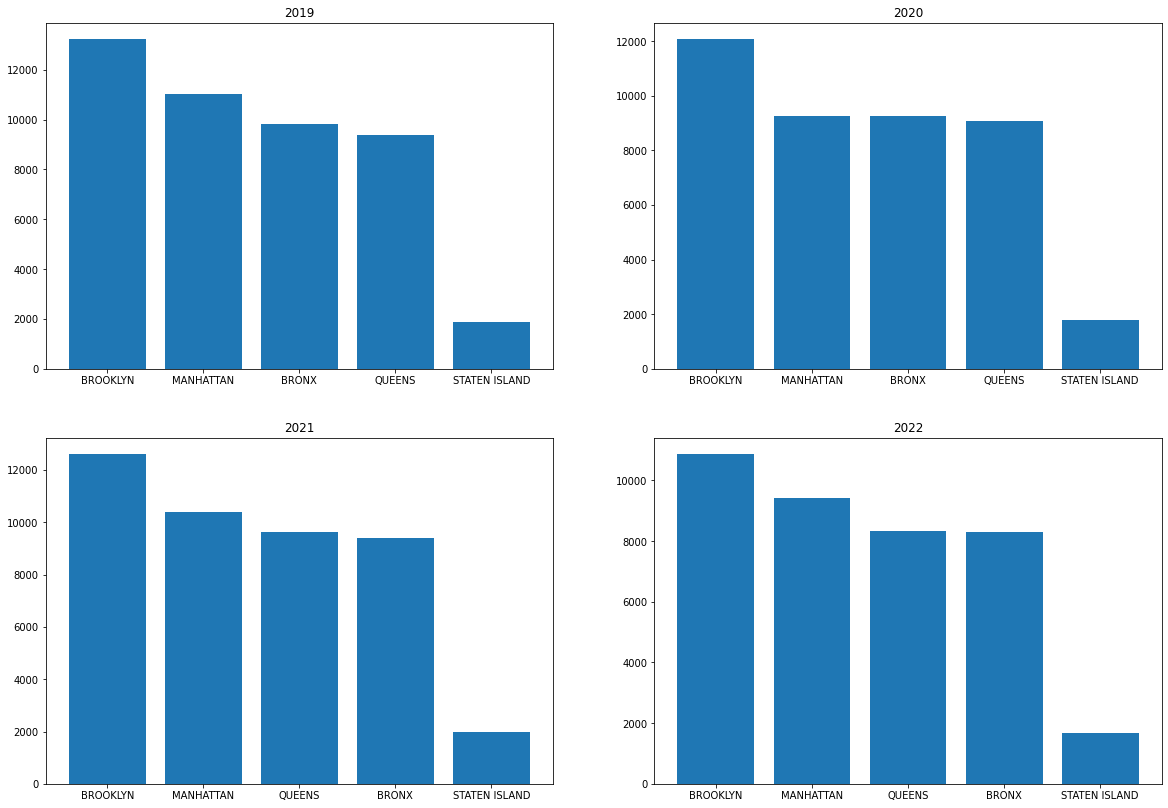

In [88]:
import matplotlib.pyplot as plt
# set up a plot of 4 subplots
fig, axs = plt.subplots(2, 2,figsize=(20,14))

years_df = [crime_19, crime_20, crime_21, crime_22]
years = ['2019','2020','2021','2022']
# list of all dfs
# years_df = [crime_2019, crime_2020, crime_2021, crime_2022]
ind = 0
for i in range(1,5):
  plt.subplot(2,2,i)
  plt.bar(years_df[ind]['Borough'].value_counts().index.tolist(), years_df[ind]['Borough'].value_counts().values)
  plt.title(years[ind])
  ind+=1

###Trend by Temporal Features

#### Trend By Month (Every Year)

In [68]:
# create summary statistics for crime by month
months = range(1,13)
#crime_by_month['Years'] = ['2019','2020','2021','2022']
months_str = []
for m in months:
  months_str.append(m) # for indexing by month in the later step

In [69]:
crime_by_boro_19 = pd.DataFrame(columns = ['Month','Number of Crime Cases', 'Borough'])
boro_name = ['MANHATTAN', 'BROOKLYN', 'QUEENS', 'BRONX', 'STATEN ISLAND']
year_dfs = [crime_19, crime_20, crime_21, crime_22]
year_tables = []

ind = 0
for y in year_dfs:
  curr_table = pd.DataFrame(columns = ['Month','Number of Crime Cases', 'Borough'])
  for b in boro_name:
    b_df = y.loc[y['Borough']==b]
    for m in months_str:
      b_m_df = b_df.loc[b_df['Month'] == m]
      crime_of_month = len(b_m_df)
      new_data = {'Month': m, 'Number of Crime Cases': crime_of_month, 'Borough':b}
      curr_table = curr_table.append(new_data, ignore_index=True)
  curr_table['Number of Crime Cases'] = curr_table['Number of Crime Cases'].replace(['0',0],np.nan)
  year_tables.append(curr_table)

In [70]:
import plotly.express as px
# create another set of subplots for by borough, by month crimes in each 
year = 2019
for i in range(4):
  fig_boro_year = px.line(year_tables[i], x="Month", y="Number of Crime Cases", color='Borough', title = year)
  year+=1
  fig_boro_year.show()

In [ ]:
crime_by_month = pd.DataFrame(columns = ['Month','Number of Crime Cases', 'Year'])
ind = 0
for y in years:
  y_df = years_df[ind]
  ind+=1
  for m in months_str:
    y_m_df = y_df.loc[y_df['Month'] == m]
    crime_of_month = len(y_m_df)
    new_data = {'Month': m, 'Number of Crime Cases': crime_of_month, 'Year':y}
    crime_by_month = crime_by_month.append(new_data, ignore_index=True)

In [ ]:
# replace 0 cases with NaN (for Oct-Dec 2022)
crime_by_month['Number of Crime Cases'] = crime_by_month['Number of Crime Cases'].replace(['0',0],np.nan)

In [ ]:
import plotly.express as px
fig = px.line(crime_by_month, x="Month", y="Number of Crime Cases", color='Year')
fig.show()

In [72]:
# Crime cases by Month and Borough
df_boro_month = pd.DataFrame(columns = ['Month','Number of Crime Cases', 'Borough'])
for b in boro_name:
  b_df = df.loc[df['Borough']==b]
  for m in months_str:
    b_m_df = b_df.loc[b_df['Month'] == m]
    crime_of_month = len(b_m_df)
    new_data = {'Month': m, 'Number of Crime Cases': crime_of_month, 'Borough':b}
    df_boro_month = df_boro_month.append(new_data, ignore_index=True)

In [73]:
df_boro_month

,Month,Number of Crime Cases,Borough
0,1,3351,MANHATTAN
1,2,3245,MANHATTAN
2,3,3485,MANHATTAN
3,4,3232,MANHATTAN
4,5,3538,MANHATTAN
5,6,3833,MANHATTAN
6,7,3709,MANHATTAN
7,8,3815,MANHATTAN
8,9,3811,MANHATTAN
9,10,2937,MANHATTAN


In [74]:
fig_df_boro_month = px.line(df_boro_month, x="Month", y="Number of Crime Cases", color='Borough',
                            title='Crime cases by Month and Borough')
fig_df_boro_month.show()

#### Trend By Hour (Every Year)

In [75]:
hours = range(0,24)
year_dfs = [crime_19, crime_20, crime_21, crime_22]
year_tables_hours = []

ind = 0
for y in year_dfs:
  curr_table = pd.DataFrame(columns = ['Hour','Number of Crime Cases', 'Borough'])
  for b in boro_name:
    b_df = y.loc[y['Borough']==b]
    for h in hours:
      b_m_df = b_df.loc[b_df['Hour'] == h]
      crime_of_hour = len(b_m_df)
      new_data = {'Hour': h, 'Number of Crime Cases': crime_of_hour, 'Borough':b}
      curr_table = curr_table.append(new_data, ignore_index=True)
  curr_table['Number of Crime Cases'] = curr_table['Number of Crime Cases'].replace(['0',0],np.nan)
  year_tables_hours.append(curr_table)

In [76]:
df_boro_hour = pd.DataFrame(columns = ['Hour','Number of Crime Cases', 'Borough'])
for b in boro_name:
  b_df = y.loc[y['Borough']==b]
  for h in hours:
    b_m_df = b_df.loc[b_df['Hour'] == h]
    crime_of_hour = len(b_m_df)
    new_data = {'Hour': h, 'Number of Crime Cases': crime_of_hour, 'Borough':b}
    df_boro_hour = df_boro_hour.append(new_data, ignore_index=True)
  df_boro_hour['Number of Crime Cases'] = df_boro_hour['Number of Crime Cases'].replace(['0',0],np.nan)

In [77]:
fig_df_boro_hour = px.line(df_boro_hour, x="Hour", y="Number of Crime Cases", color='Borough', title = "Crime cases by hour and borough")
fig_df_boro_hour.show()

In [78]:
# by year
year = 2019
for i in range(4):
  fig_boro_hour = px.line(year_tables_hours[i], x="Hour", y="Number of Crime Cases", color='Borough', title = year)
  year+=1
  fig_boro_hour.show()

In [80]:
crime_19['Offence_Level'].value_counts()

MISDEMEANOR    15762
VIOLATION      14953
FELONY         14647
Name: Offence_Level, dtype: int64

In [81]:
crime_type = list(crime_19['Offence_Level'].value_counts().index)

In [83]:
crime_type_by_hour = pd.DataFrame(columns = ['Crime Type','Number of Crime Cases', 'Percentage', 'Hour'])

for h in hours:
  h_df = df.loc[df['Hour']==h]
  # print(len(h_df))
  # print("curr hour: ", h)
  for t in crime_type:
    # print("curr type: ", t)
    t_h_df = h_df.loc[h_df['Offence_Level'] == t]
    crime_of_hour = len(t_h_df)
    curr_perc = crime_of_hour/len(h_df)
    curr_perc = str(round(curr_perc*100,ndigits=2))+ '%'
    new_data = {'Crime Type': t, 'Number of Crime Cases': crime_of_hour, 'Percentage': curr_perc, 'Hour':h}
    crime_type_by_hour = crime_type_by_hour.append(new_data, ignore_index=True)

In [84]:
crime_type_by_hour

,Crime Type,Number of Crime Cases,Percentage,Hour
0,MISDEMEANOR,2421,33.04%,0
1,VIOLATION,1793,24.47%,0
2,FELONY,3114,42.49%,0
3,MISDEMEANOR,1700,32.94%,1
4,VIOLATION,1366,26.47%,1
...,...,...,...,...
67,VIOLATION,2339,32.0%,22
68,FELONY,2639,36.1%,22
69,MISDEMEANOR,2072,31.58%,23
70,VIOLATION,1939,29.55%,23


In [85]:
fig_crime_type_hour = px.bar(crime_type_by_hour, x="Hour", y="Number of Crime Cases", 
                             text='Percentage', color='Crime Type',title='Type of Crime by Hours')
fig_crime_type_hour.show()

#### Trend by Holiday

In [107]:
is_holiday = [0, 1]

In [114]:
crime_type_by_holiday = pd.DataFrame(columns = ['Crime Type','Number of Crime Cases', 'Holiday'])
for t in crime_type:
  t_df = df.loc[df['Offence_Level']==t]
  for h in is_holiday:
    h_t_df = t_df.loc[t_df['Holiday']==h]
    crime_by_holiday = len(h_t_df)
    #curr_perc = crime_by_age/len(t_df)
    new_data = {'Crime Type': t,'Number of Crime Cases': crime_by_holiday,'Holiday': h}
    crime_type_by_holiday = crime_type_by_holiday.append(new_data, ignore_index=True)
crime_type_by_holiday

,Crime Type,Number of Crime Cases,Holiday
0,MISDEMEANOR,54017,0
1,MISDEMEANOR,2431,1
2,VIOLATION,54101,0
3,VIOLATION,2453,1
4,FELONY,53836,0
5,FELONY,2523,1


In [115]:
fig_holiday = px.bar(crime_type_by_holiday, x="Crime Type", y="Number of Crime Cases", color='Holiday')
fig_holiday.show()

#### Trend by Day of Week

In [116]:
# create summary statistics for crime by Day of Week
dow = range(0,7)
dow_str = []
for d in dow:
  dow_str.append(d) # for indexing by DoW in the later step

In [120]:
crime_by_dow = pd.DataFrame(columns = ['Day of Week','Number of Crime Cases', 'Year'])
ind = 0
for y in years:
  y_df = years_df[ind]
  ind+=1
  for d in dow_str:
    y_m_df = y_df.loc[y_df['DoW'] == d]
    crime_of_month = len(y_m_df)
    new_data = {'Day of Week': d, 'Number of Crime Cases': crime_of_month, 'Year':y}
    crime_by_dow = crime_by_dow.append(new_data, ignore_index=True)

In [121]:
# replace 0 cases with NaN (for Oct-Dec 2022)
crime_by_dow['Number of Crime Cases'] = crime_by_dow['Number of Crime Cases'].replace(['0',0],np.nan)

In [123]:
fig_dow = px.line(crime_by_dow, x="Day of Week", y="Number of Crime Cases", color='Year', title='Crime cases by Day of Week')
fig_dow.show()

### Trend by Victim Profile

#### Victim Age

In [104]:
age_group = list(crime_19['Victim_Agegroup'].value_counts().index)
age_group.remove('UNKNOWN')

In [105]:
crime_type_by_age = pd.DataFrame(columns = ['Crime Type','Number of Crime Cases', 'Victim Age'])

for t in crime_type:
  t_df = df.loc[df['Offence_Level']==t]
  for a in age_group:
    a_t_df = t_df.loc[t_df['Victim_Agegroup']==a]
    crime_by_age = len(a_t_df)
    #curr_perc = crime_by_age/len(t_df)
    new_data = {'Crime Type': t,'Number of Crime Cases': crime_by_age,'Victim Age': a}
    crime_type_by_age = crime_type_by_age.append(new_data, ignore_index=True)

In [106]:
fig_age = px.bar(crime_type_by_age, x="Crime Type", y="Number of Crime Cases", 
              color='Victim Age', title = 'Crime Type by Victim Age')
fig_age.show()

#### Victim Sex

In [94]:
vic_sex = list(crime_19['Victim_Sex'].value_counts().index)

In [95]:
crime_type_by_sex = pd.DataFrame(columns = ['Crime Type','Number of Crime Cases', 'Victim Sex'])

for t in crime_type:
  t_df = df.loc[df['Offence_Level']==t]
  for s in vic_sex:
    s_t_df = t_df.loc[t_df['Victim_Sex']==s]
    crime_by_sex = len(s_t_df)
    new_data = {'Crime Type': t,'Number of Crime Cases': crime_by_sex, 'Victim Sex': s}
    crime_type_by_sex = crime_type_by_sex.append(new_data, ignore_index=True)

In [96]:
fig_sex = px.bar(crime_type_by_sex, x="Crime Type", y="Number of Crime Cases", color='Victim Sex',
              title = 'Crime Type by Victim Sex')
fig_sex.show()

#### Victim Race

In [100]:
vic_race =  list(crime_19['Victim_Race'].value_counts().index)
vic_race.remove('UNKNOWN')

In [101]:
crime_type_by_race = pd.DataFrame(columns = ['Crime Type','Number of Crime Cases', 'Victim Race'])

for t in crime_type:
  t_df = df.loc[df['Offence_Level']==t]
  for r in vic_race:
    r_t_df = t_df.loc[t_df['Victim_Race']==r]
    crime_by_race = len(r_t_df)
    new_data = {'Crime Type': t,'Number of Crime Cases': crime_by_race, 'Victim Race': r}
    crime_type_by_race = crime_type_by_race.append(new_data, ignore_index=True)

In [102]:
fig_race = px.bar(crime_type_by_race, x="Crime Type", y="Number of Crime Cases", 
              color='Victim Race', title='Crime Type by Victim Race')
fig_race.show()

### Trend by Status

In [125]:
status = list(crime_19['Status'].value_counts().index)

In [129]:
crime_type_by_status = pd.DataFrame(columns = ['Crime Type','Number of Crime Cases', 'Status'])

for t in crime_type:
  t_df = df.loc[df['Offence_Level']==t]
  for s in status:
    s_t_df = t_df.loc[t_df['Status']==s]
    crime_by_status = len(s_t_df)
    new_data = {'Crime Type': t,'Number of Crime Cases': crime_by_status, 'Status': s}
    crime_type_by_status = crime_type_by_status.append(new_data, ignore_index=True)

In [130]:
fig_status = px.bar(crime_type_by_status, x="Crime Type", y="Number of Crime Cases", 
              color='Status', title='Crime Type by Status')
fig_status.show()